# Data Processing and Model Tuning

In this notebook, we will explore how to preprocess data and tune a machine learning model to achieve optimal performance. The process will include:
- Data cleaning and transformation
- Feature selection and scaling
- Model selection and hyperparameter tuning

We'll demonstrate these steps using a real-world dataset and employ techniques like GridSearchCV for model tuning.


### Step 1. Import Necessary Libraries & Loading the Data


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("https://storage.googleapis.com/courses_data/Machine%20Learning%20Titanic/train.csv")
test_data = pd.read_csv("https://storage.googleapis.com/courses_data/Machine%20Learning%20Titanic/test.csv")

the train set has 891 observations (passengers) and 12 features (columns). The test set contains 418 observations but 11 features. The target column is named 'Survived' and indicates if a passenger survived the shipwreck.

### Step 2. Data Cleansing

- Obtain an initial overview of our data, including its completeness and data types.

In [ ]:
print(train_data.info())
print("\n")
print(test_data.info())

Columns 'Cabin', 'Age', 'Fare' and Embarked have missing values (NaN).
The decision regarding the management of the missing values is usually made based on the number of missing values in relation to the total dataset.

In [3]:
"""
First, we decide to completely remove the 'Cabin' column, 
which has quite limited information, 
and the missing values outnumber the existing ones.
"""
train_data = train_data.drop(columns=['Cabin'])
test_data = test_data.drop(columns=['Cabin'])

In [4]:
"""
Next, for the 'Age' column, we will fill in the missing values 
by the mean age of women and men accordingly. 
"""

mean_age_by_sex = train_data.groupby('Sex')['Age'].mean()

train_data['Age'] = train_data['Age'].fillna(train_data['Sex'].map(mean_age_by_sex))
train_data['Age'] = [int(x) for x in train_data['Age']]

test_data['Age'] = test_data['Age'].fillna(test_data['Sex'].map(mean_age_by_sex))
test_data['Age'] = [int(x) for x in test_data['Age']]

In [5]:
"""
For the `Embarked` column we only have 2 missing values. 
Since this column is categorical we cannot compute a mean value.
Instead we will fill the missing values with the value of the most popular port (mode).
"""
most_popular_embarked = train_data["Embarked"].mode()[0]
train_data["Embarked"] = train_data["Embarked"].fillna(most_popular_embarked)

In [6]:
"""
For the `Fare` column we only have 1 missing value on the test set, 
which we fill based on the train set mean 
"""
mean_fare = train_data["Fare"].mean()
test_data["Fare"] = test_data["Fare"].fillna(mean_fare)

### Step 3. Feature Engineering

- The first step lies in the implementation of **dummy variables**, meaning transforming categorical data into binary values, as Machine learning models rely on numerical input to make predictions and decisions.

In [7]:
train_data = pd.get_dummies(train_data, columns=["Embarked", "Pclass"], drop_first=True) 
test_data = pd.get_dummies(test_data, columns=["Embarked", "Pclass"], drop_first=True)

train_data["Sex"] = train_data["Sex"].map({'male': 0, 'female': 1})
test_data["Sex"] = test_data["Sex"].map({'male': 0, 'female': 1})


- The second step involves **Feature Selection** meaning discarding less informative features to reduce model's complexiting and avoid potential overfitting. 

In [9]:
"""
The following features should not be retained based on the given information 
"""
train_data = train_data.drop(columns=["PassengerId", "Ticket"])
test_data = test_data.drop(columns=["PassengerId", "Ticket"])

- The last step involves **Feature Extraction** meaning creating new features from the existing ones by applying various mathematical and statistical techniques. 

In [10]:
"""
Our goal is to isolate this title and subsequently examine the existing titles
of the passengers. Based on these titles, we may be able to establish a
correlation with survival or lack thereof.
"""
train_data["Title"] = [x.split(".")[0].split(",")[1].strip() for x in train_data["Name"]]
test_data["Title"] = [x.split(".")[0].split(",")[1].strip() for x in test_data["Name"]]

print(train_data["Title"].value_counts(), "\n")
print(test_data["Title"].value_counts())

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64 

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64


In [11]:
"""
We observe that others than the usual Mr and Mrs (Miss) titles also exist.
For that reason we create a new feature for passengers that have a special title
"""
condition = (train_data['Title'] != 'Mr') & (train_data['Title'] != 'Mrs') & (train_data['Title'] != 'Miss')
train_data['Special_Title'] = np.where(condition, 1, 0)

def is_special_title(title):
    if title in ['Mr', 'Mrs', 'Miss']:
        return 0
    else:
        return 1
    
test_data['Special_Title'] = test_data['Title'].apply(is_special_title)

train_data = train_data.drop(columns=["Name", "Title"])
test_data = test_data.drop(columns=["Name", "Title"])

### Step 4. Feature Scaling

This process prepares and standardizes the input features bringing them to a common scale and distribution before feeding them into machine-learning models.

In [14]:
y_train = train_data["Survived"]
X_train = train_data.drop(columns=["Survived"])

scaler = MinMaxScaler()
# The MinMaxScaler scales the data between 0 and 1.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_data)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=test_data.columns)

X_train_scaled_df = pd.concat([X_train_scaled_df, y_train], axis=1)


### Step 5. Hyperparameter Tuning - GridSearchCV

- In the first place, we use RandomForest algorithm with its **default parameters**

In [15]:
# Isolate the target variable named `Survived`
y = X_train_scaled_df["Survived"]
X = X_train_scaled_df.drop("Survived", axis=1)

# Instantiate the model with default parameters -we only set `random_state` to ensure reproducibility
clf = RandomForestClassifier(random_state=42)

# Instantiate the cross validation strategy -Stratified with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Compute mean accuracy of model
scores = cross_val_score(clf, X, y, cv=stratified_kfold, scoring='accuracy')

print(f"Scores for each fold: {scores}")
print(f"Mean Accuracy Score: {scores.mean()}")

Scores for each fold: [0.83798883 0.82022472 0.80898876 0.78651685 0.78651685]
Mean Accuracy Score: 0.8080472035653757


- Secondly we use **GridSearchCV**, a powerful tool in the scikit-learn (sklearn) library that simplifies the process of hyperparameter tuning for machine learning models. It automates the search for the best combination of hyperparameters to optimize the performance of a machine learning algorithm.

In [16]:
param_grid = {
    "n_estimators": [100, 200, 300], # default 100
    "max_depth": [None, 4, 8, 12], # default None
    "criterion": ["gini", "entropy", "log_loss"] # default "gini"
}

# Instantiate again the same model with the same `random_state` in order to able to fairly compare the results
clf = RandomForestClassifier(random_state=42)

# Apply the model on each combination of the the above parameters - total number=3*4*3=36 candidates * 5 (folds)= 180fits.
model = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1)
model.fit(X, y)

print(f"\nThe parameters that achieved the best Accuracy Score: {model.best_params_}\n")
print(f"Mean cross-validated score of the best estimator: {model.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

The parameters that achieved the best Accuracy Score: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 300}

Mean cross-validated score of the best estimator: 0.8361370912058252


As shown above, we tested 36 different combinations, resulting in a total of 180 fits using 5-fold cross-validation . With this tuning, we managed to increase the accuracy of our model from 80.08% to 83.61%

### Step 6. Feature Importance

Top 10 Features:
         Feature  Importance
0            Sex    0.472897
4           Fare    0.165515
8       Pclass_3    0.143489
1            Age    0.086857
2          SibSp    0.038507
6     Embarked_S    0.025871
3          Parch    0.024680
7       Pclass_2    0.017792
9  Special_Title    0.016738
5     Embarked_Q    0.007654


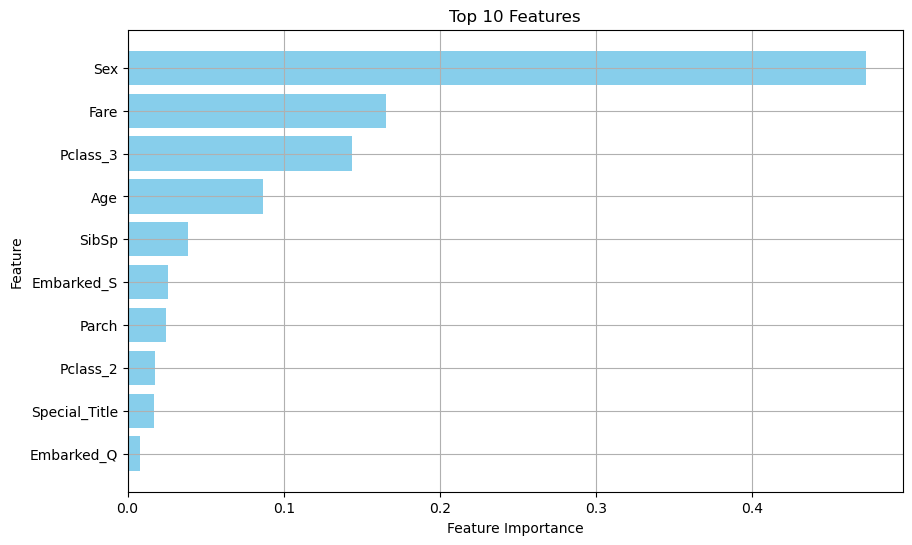

In [33]:
# Fit the model with the best hyperparameters
best_rf_model = model.best_estimator_
best_rf_model.fit(X,y)

# Calculate feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Print the top N features contributing to the model's prediction
top_n = 10
print(f"Top {top_n} Features:")
print(feature_importances_df.head(top_n))

top_features = feature_importances_df.iloc[:top_n]
plt.figure(figsize=(10,6))
plt.barh(top_features.Feature, top_features.Importance, color='skyblue')
plt.title(f'Top {top_n} Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid()
plt.gca().invert_yaxis()
plt.show()

We can observe that the 'Sex' feature plays the most crucial role when the model predicts survival status. Additionally, 'Fare' and 'Pclass_3' also make significant contributions. Features with importance scores close to zero may be candidates for elimination in future experiments, as they appear to provide little to no value for our model's predictability.